In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits 


from scipy import interpolate
from funcs.ad import sample_AD_for_custom_distribution, get_pvalue_from_AD_statistic



def get_cumulative_distributions(df, dfphases, get_secs_cadences):
    """Calculate the cumulative distribution function of observed
    flares, while accounting for the number of observed flares in
    a light curve with a given detection threshold.

    Parameters:
    -----------
    df : DataFrame
        detected flares table, with a flag qcs that denotes the LC
    dfphases : DataFrame
        table that lists the observed phases, with a column for each LC
    get_secs_cadences : list
        format: [(Sector, cadence in minutes), (.., ..), (.., ..)]
        Sector is an int
        cadence is a float
    """
    # Measured number of flares in each bin
    F = dfphases.shape[0]
    n_i = np.full(F, 1)

    # Calculate cumulative frequency distribution
    cum_n_i = np.cumsum(n_i) / F

    # Expected number of flares in each bin

    # setup array for each bin
    n_exp = np.zeros_like(n_i).astype(float)

    # sum over different sectors to account for different detection thresholds
    for sec, cad in get_secs_cadences:
        obstimes_k = dfphases[sec]
        # print(obstimes_k)
        tot_obstimes_k = obstimes_k.sum() # total observation time in that Sector in minutes
        # print(tot_obstimes_k)
        F_k = df[df.qcs==sec].shape[0] # number of flares in that Sector
        # print(F_k)
        n_exp_k = (obstimes_k * F_k / tot_obstimes_k).values 
        # print(n_exp_k)
        n_exp += n_exp_k
        # print(n_exp)
    # for debugging: 
    # calculate the old cumulative distribution that 
    # ignores the different detection thresholds
    # cum_n_exp_alt = dfphases.sum(axis=1).values.cumsum() / dfphases.sum(axis=1).values.sum()
    
    # Calculate cumulative frequency distribution
    cum_n_exp = n_exp.cumsum() / n_exp.sum()
    
    return n_i, n_exp, cum_n_exp, cum_n_i#, cum_n_exp_alt return alternative only if necessary


In [2]:
import glob
files = glob.glob('../data/hip67522/CHEOPS-products-*/Outdata/00000/hip67522_CHEOPS-products-*_im.fits')
files

['../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/hip67522_CHEOPS-products-20240319122713_im.fits',
 '../data/hip67522/CHEOPS-products-20240603073928/Outdata/00000/hip67522_CHEOPS-products-20240603073928_im.fits',
 '../data/hip67522/CHEOPS-products-20240522113135/Outdata/00000/hip67522_CHEOPS-products-20240522113135_im.fits',
 '../data/hip67522/CHEOPS-products-20240412070023/Outdata/00000/hip67522_CHEOPS-products-20240412070023_im.fits',
 '../data/hip67522/CHEOPS-products-20240311145359/Outdata/00000/hip67522_CHEOPS-products-20240311145359_im.fits',
 '../data/hip67522/CHEOPS-products-20240312075007/Outdata/00000/hip67522_CHEOPS-products-20240312075007_im.fits',
 '../data/hip67522/CHEOPS-products-20240529072301/Outdata/00000/hip67522_CHEOPS-products-20240529072301_im.fits',
 '../data/hip67522/CHEOPS-products-20240622064513/Outdata/00000/hip67522_CHEOPS-products-20240622064513_im.fits',
 '../data/hip67522/CHEOPS-products-20240325102059/Outdata/00000/hip67522_CHEOPS-products

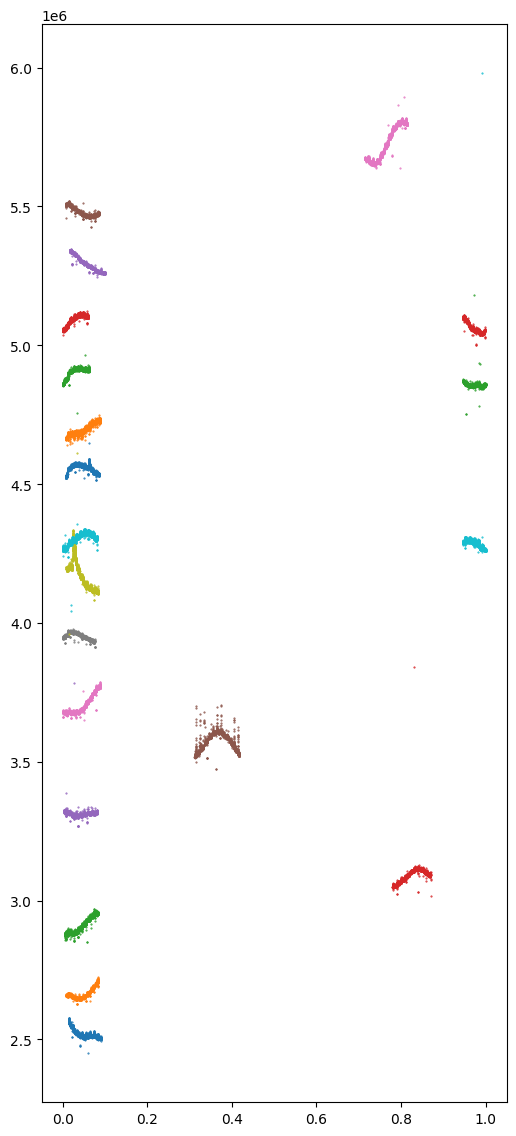

In [3]:
cheops_phases = np.array([])
midpoint = 2460392.61598
period = 6.959503
# period = 1.44
offs =0
plt.figure(figsize=(6,14))

time = np.array([])
flux = np.array([])

for file in files:
    hdulist = fits.open(file)


    # get the image data
    image_data = hdulist[1].data

    t, f, ferr, roll = image_data["BJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"]

    # make sure the data is in fact 10s cadence
    assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

    # big endian to little endian
    t = t.byteswap().newbyteorder()
    f = f.byteswap().newbyteorder()
    ferr = ferr.byteswap().newbyteorder()
    roll = roll.byteswap().newbyteorder()

    time = np.concatenate([time, t])
    flux = np.concatenate([flux, f])


    # convert t to phase
    phase = ((t - midpoint) % period) / period


    cheops_phases = np.concatenate([cheops_phases, phase])

    plt.plot(phase, f+offs, ".", markersize=1)
    offs += 200000
    # plt.xlim(0,0.1)
    # plt.ylim(2.25e6, 2.8e6)


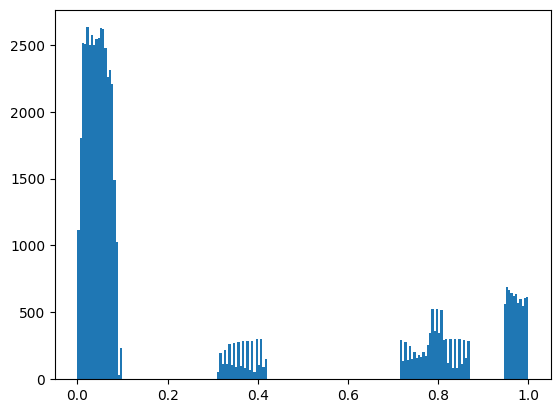

In [4]:
plt.hist(cheops_phases.flatten(), bins=200);

In [5]:
# random draw three phases

binary = [0.02 < np.all(np.random.choice(cheops_phases, 3) < 0.07) for i in range(10000)]

binary = np.array(binary)
binary[binary==True].shape[0] / binary.shape[0]

0.1778

In [6]:
import pandas as pd

def get_observed_phases(p, lcs, cadences, qcs, phaseshift=0.):
    """Takes 
    
    
    Parameters:
    -----------
    mode : str
        either "Rotation" or "Orbit"
    p : array
        array of phases, for the KS-test it should be the 
        measured flare phases, for the AD test, any well 
        sampled grid of phases works
    phaseshift : float
        default = 0
        
    Return:
    -------
    pandas.DataFrame - one column per Sector or Quarter,
                       and observing time per phase in each row
    list - mids of bins for each phase row in the DataFrame
    """
    
    # bin array is two elements longer than the number of bins
    # to include 0 and 1
    bins = p 
    # add zero and one
    bins = np.concatenate([bins, [1]])
    bins = np.concatenate([[0], bins])
#     print(bins)
    phases = pd.DataFrame()
#     plt.figure(figsize=(8, 3))
    for q, cadence, ph in list(zip(qcs, cadences, lcs)):
        

        counts, bins = np.histogram((ph + phaseshift) % 1, bins=bins)
            
        # get observing times for each Sector
        phases[q] = counts * cadence

    return phases, (bins[1:] + bins[:-1])/2


In [7]:
import lightkurve as lk


In [8]:
lclist = lk.search_lightcurvefile("HIP 67522", mission="TESS", author="SPOC", exptime=120)
lclist

/tmp/ipykernel_24668/2521128014.py:1: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lclist = lk.search_lightcurvefile("HIP 67522", mission="TESS", author="SPOC", exptime=120)


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 11,2019,SPOC,120,166527623,0.0
1,TESS Sector 38,2021,SPOC,120,166527623,0.0
2,TESS Sector 64,2023,SPOC,120,166527623,0.0


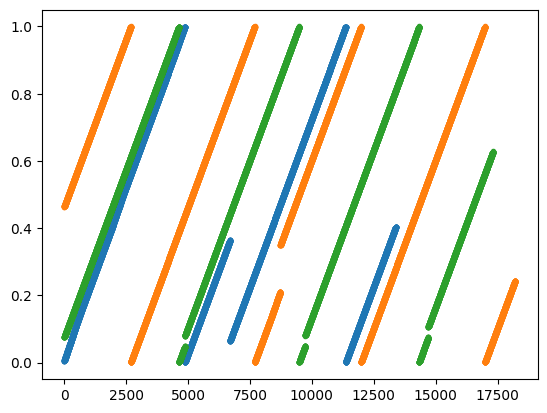

In [75]:
midtime = 2458604.02358

period = 6.959503

lcs = []
for entry in lclist:
    lc = entry.download().remove_outliers()
    phases = (lc.time.value - midtime) % period / period
    lcs.append(phases)

    plt.plot(phases, ".")

In [57]:
lcs

[array([0.00483561, 0.00503518, 0.00523475, ..., 0.40363668, 0.40383624,
        0.40403581]),
 array([0.46391657, 0.46411613, 0.4643157 , ..., 0.24346134, 0.2436609 ,
        0.24386046]),
 array([0.07526688, 0.07546646, 0.07566603, ..., 0.62763256, 0.62783213,
        0.6280317 ])]

In [79]:
lcs.append(cheops_phases)
lcs

[array([0.00483561, 0.00503518, 0.00523475, ..., 0.40363668, 0.40383624,
        0.40403581]),
 array([0.46391657, 0.46411613, 0.4643157 , ..., 0.24346134, 0.2436609 ,
        0.24386046]),
 array([0.07526688, 0.07546646, 0.07566603, ..., 0.62763256, 0.62783213,
        0.6280317 ]),
 array([0.01439796, 0.01441463, 0.0144313 , ..., 0.81463948, 0.81465615,
        0.81467282])]

In [65]:
lcs = [cheops_phases]

[0.         0.01754594 0.022      0.022      0.02932041 0.04032543
 0.04435866 0.05725983 0.059      0.059      0.062      0.062
 0.11246682 0.15009205 0.19953866 0.6125841  0.72928557 0.81175128
 0.94801832 0.98       0.98       1.        ]


100%|██████████| 20000/20000 [00:17<00:00, 1163.44it/s]


[]
20000 (20000,)
0.12090000000000004 2.2507311562077668
KstestResult(statistic=0.31180943468129396, pvalue=0.021283435473215734, statistic_location=0.062, statistic_sign=1)
[0.         0.01754594 0.022      0.022      0.02932041 0.04032543
 0.04435866 0.05725983 0.059      0.059      0.062      0.062
 0.11246682 0.15009205 0.19953866 0.6125841  0.72928557 0.81175128
 0.94801832 0.98       0.98       1.        ]


100%|██████████| 20000/20000 [00:17<00:00, 1154.26it/s]


[]
20000 (20000,)
0.1172999999999999 2.2507311562077668
KstestResult(statistic=0.31180943468129396, pvalue=0.021283435473215734, statistic_location=0.062, statistic_sign=1)
[0.         0.01754594 0.022      0.022      0.02932041 0.04032543
 0.04435866 0.05725983 0.059      0.059      0.062      0.062
 0.11246682 0.15009205 0.19953866 0.6125841  0.72928557 0.81175128
 0.94801832 0.98       0.98       1.        ]


100%|██████████| 20000/20000 [00:17<00:00, 1115.54it/s]


[]
20000 (20000,)
0.12409999999999996 2.2507311562077668
KstestResult(statistic=0.31180943468129396, pvalue=0.021283435473215734, statistic_location=0.062, statistic_sign=1)
[0.         0.01754594 0.022      0.022      0.02932041 0.04032543
 0.04435866 0.05725983 0.059      0.059      0.062      0.062
 0.11246682 0.15009205 0.19953866 0.6125841  0.72928557 0.81175128
 0.94801832 0.98       0.98       1.        ]


100%|██████████| 20000/20000 [00:17<00:00, 1116.30it/s]


[]
20000 (20000,)
0.14689999999999998 2.2507311562077668
KstestResult(statistic=0.31180943468129396, pvalue=0.021283435473215734, statistic_location=0.062, statistic_sign=1)


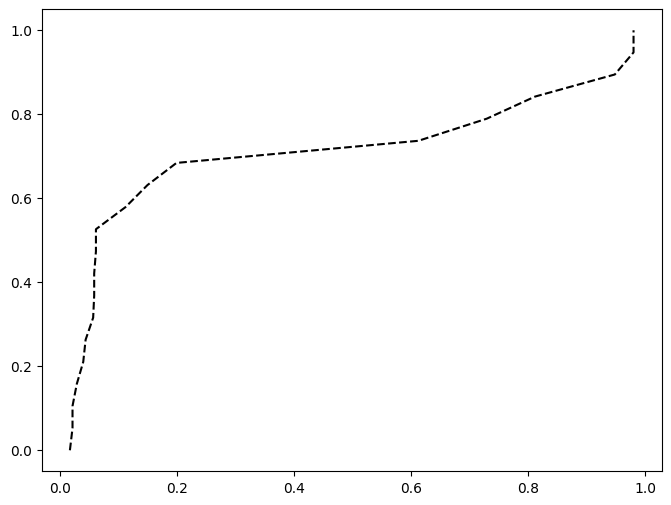

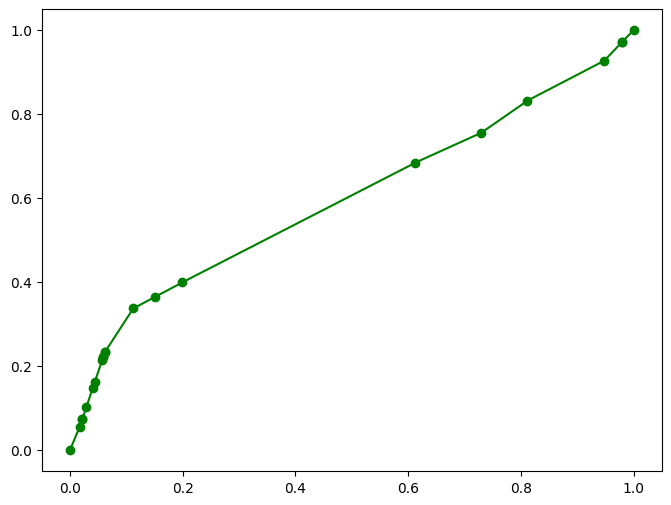

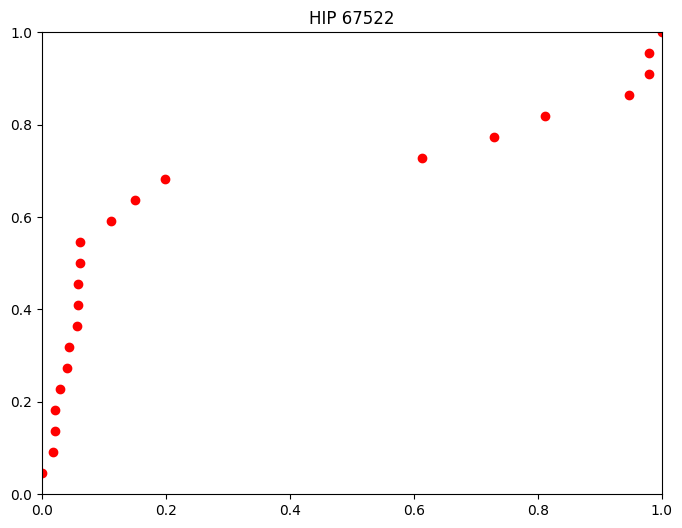

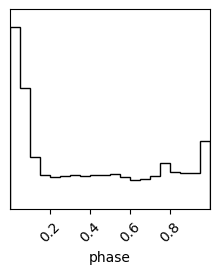

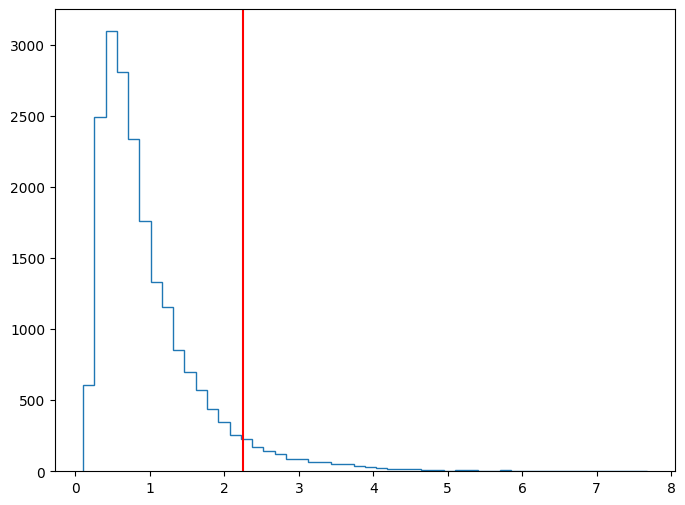

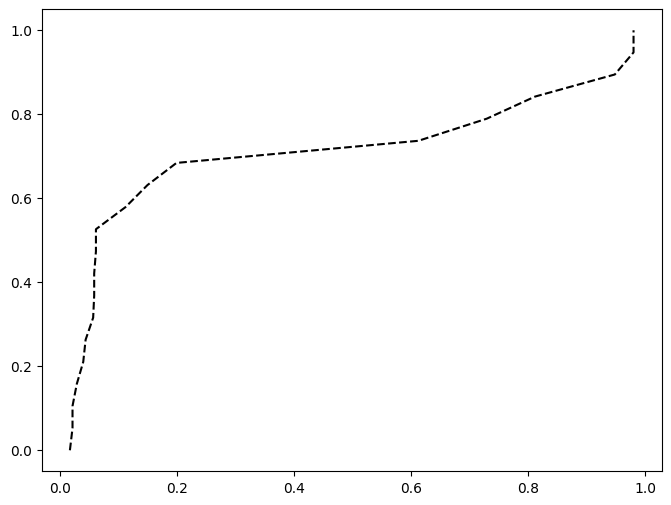

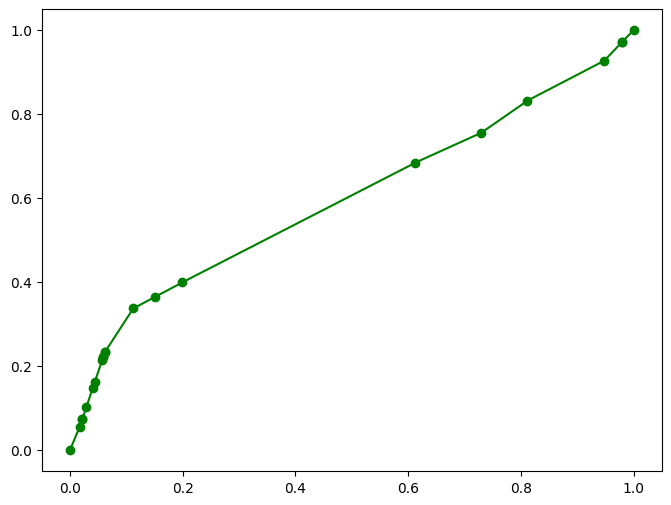

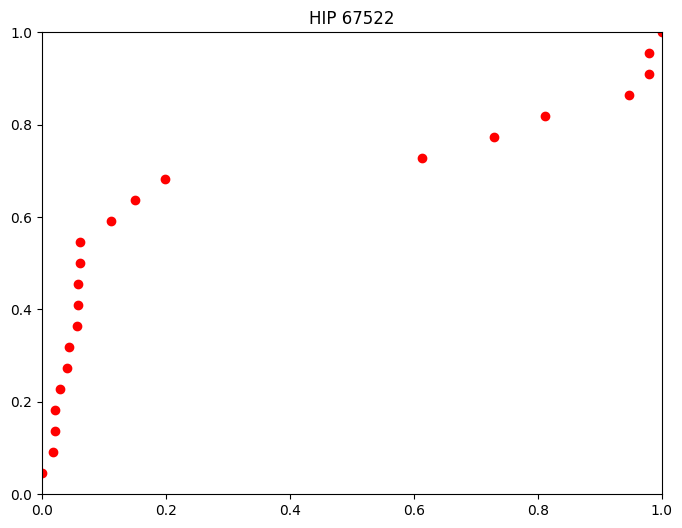

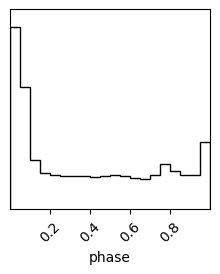

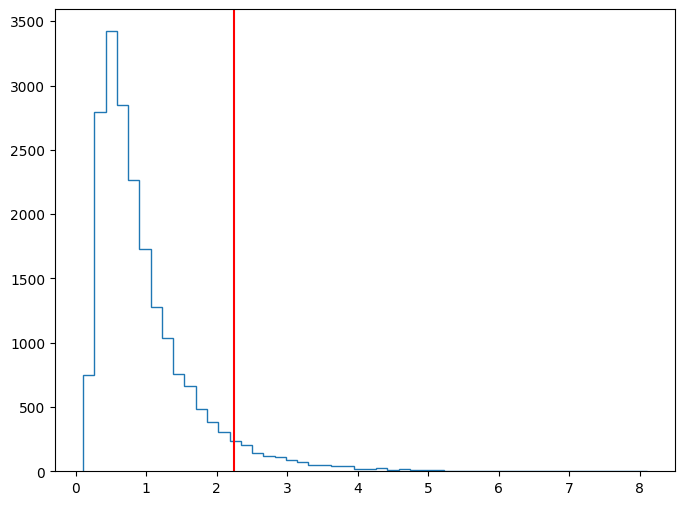

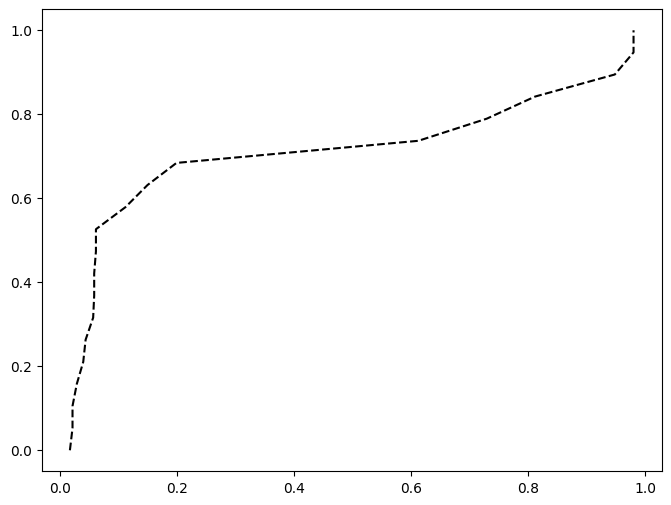

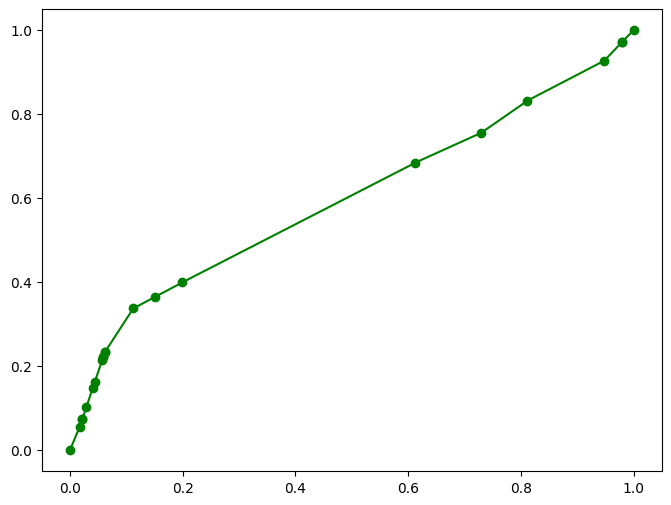

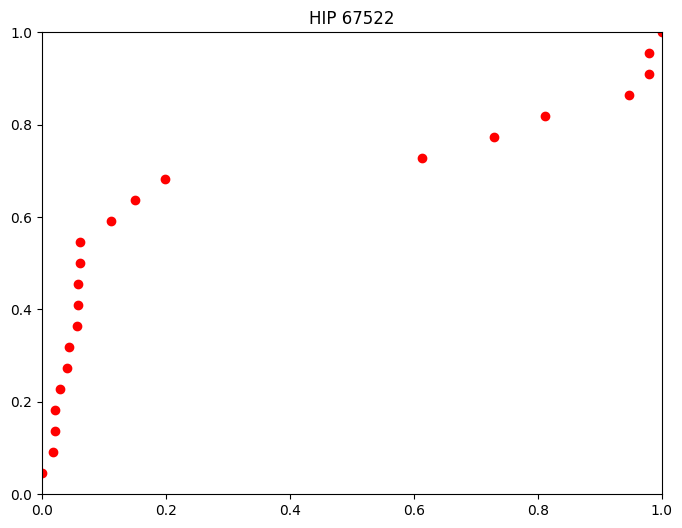

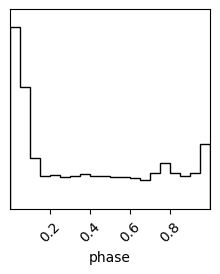

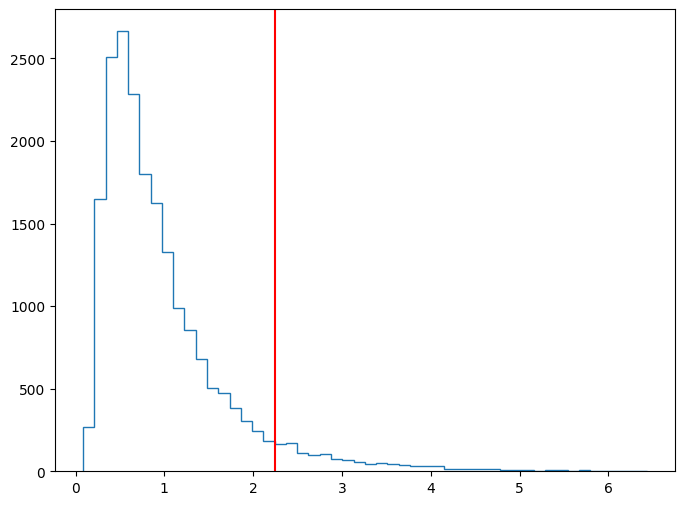

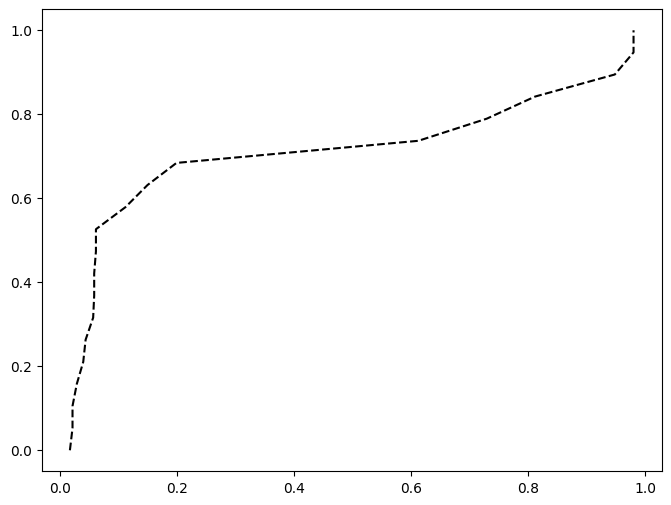

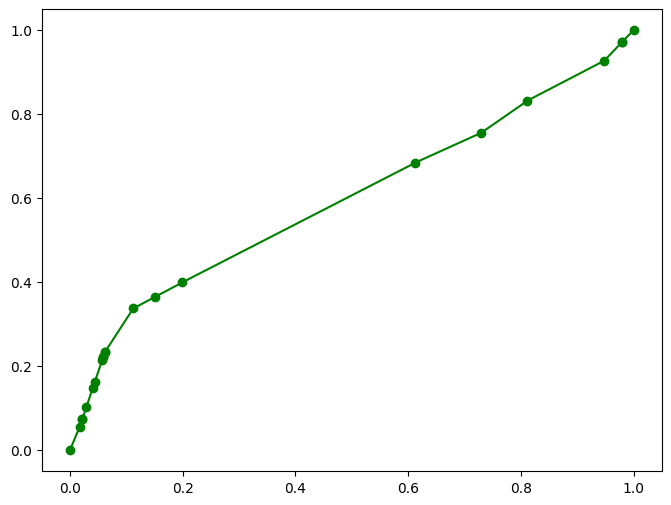

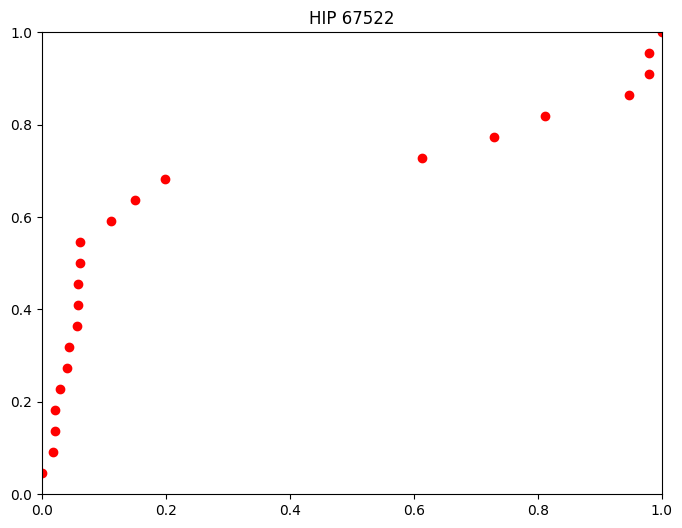

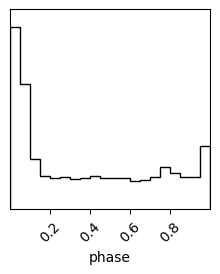

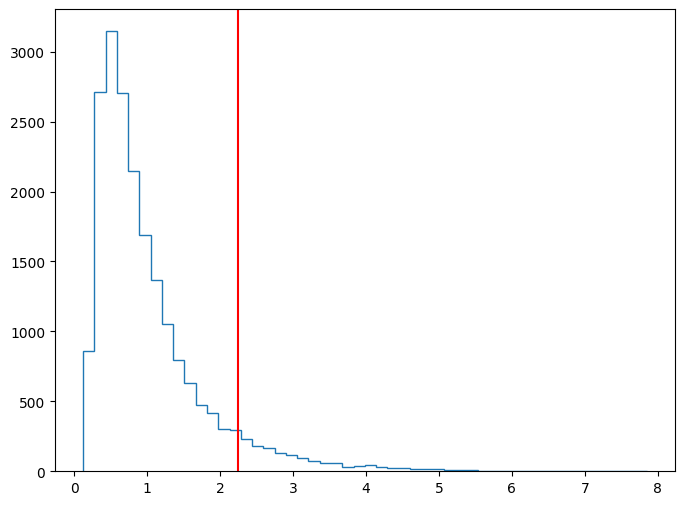

In [86]:
phaseshifts = [0.0,0.25,0.5,0.75]
pvals = []
pvalsks = []

for phaseshift in phaseshifts:



    df = pd.read_csv("2022_07_flares_vetted.csv")
    cond = (df.ID == "HIP 67522") & (df.real == 1) & (df.mask_pos_outliers_sigma>1.5)
    tessps = ((df[cond].tstart + 2457000 - midtime  ) % period / period ).values #+ phaseshift*period
    tesslc = df[cond].qcs.values

    cheopsps = np.array([0.022, 0.059, 0.062, 0.98,0.022, 0.059, 0.062, 0.98])
    cheopslc = [1,1,1,1,1,1,1,1]

    pss = np.concatenate([tessps, cheopsps])
    lcc = np.concatenate([tesslc, cheopslc])

    # pss = tessps
    # lcc = tesslc

    ps, bins = get_observed_phases(np.sort(pss), lcs, [2,2,2,10./60.], [11, 38, 64,1], phaseshift=0)#

    df = pd.DataFrame({"phases": pss, "qcs": lcc})

    n_i, n_exp, cum_n_exp, cum_n_i = get_cumulative_distributions(df, ps, [(11, 2), (38, 2), (64, 2), (1, 10./60.) ])

    # plt.plot(cum_n_i, cum_n_exp)
    plt.figure(figsize=(8,6))
    plt.plot(np.sort(pss), np.linspace(0,1,len(pss)), "k--")

  
    p = np.sort(pss)
    p = np.insert(p,0,0)
    p = np.append(p,1)


  
    cum_n_exp = np.insert(cum_n_exp, 0, 0)
    # cum_n_exp = np.append(cum_n_exp, 1)

    # print(cum_n_exp)
    # print(p)
    # print(cum_n_i)
    cum_n_i = np.insert(cum_n_i, 0, 0)

    plt.figure(figsize=(8,6))
    plt.plot(p, cum_n_exp, "o", color="green")

    # plt.plot(p, cum_n_i, "o", color="red")

    f = interpolate.interp1d(p, cum_n_exp, fill_value="extrapolate")
    ph = np.linspace(0,1,1000)
    plt.plot(ph, f(ph), c="green")


    N =20000
    # Make a diagnostic plot
    plt.figure(figsize=(8,6))
 
    # plt.plot(p,f(p), c="green")
    dsave = pd.DataFrame({"p":p, "f":f(p)})
    dsave.to_csv(f"cumhist.csv",
                    index=False)
    cumsum =  np.cumsum(np.ones_like(p)) / len(p)
    plt.scatter(p, cumsum, c="r")
    plt.title(f"HIP 67522")
    plt.xlim(0,1)
    plt.ylim(0,1)
    # plt.savefig(f"../plots/cumhist.png")
    # plt.close()

    # Finally, run the A-D test
    print(p)
    print(f)
    A2 = sample_AD_for_custom_distribution(f, p.shape[0], N)

    # This should go into the function above
    # select only the finite values
    print(np.isfinite(A2).sum(), A2.shape)
    A2 = A2[np.isfinite(A2)]

    plt.figure(figsize=(8,6))   
    plt.hist(A2, bins=50, histtype="step")

    # Calculate the p-value and A2 value using the distribution 
    # of A2 values
    pval, atest = get_pvalue_from_AD_statistic(p, f, A2)
    plt.axvline(atest, color="red")
    print(pval, atest)
    pvals.append(pval)

    from scipy.stats import kstest

    ks = kstest(p, f, args=(), N=1000, alternative='two-sided', mode='approx')
    print(ks)
    pvalsks.append(ks.pvalue)


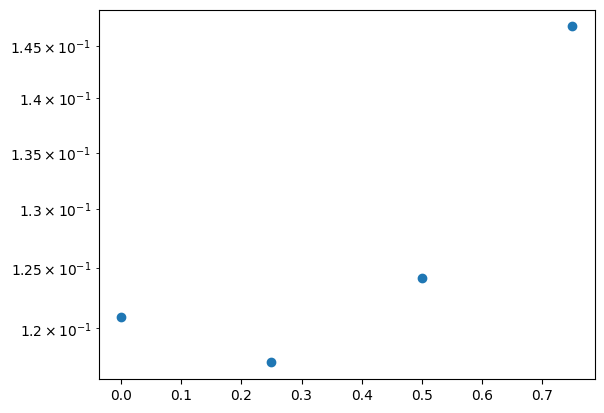

In [87]:
plt.scatter(phaseshifts, pvals)
plt.yscale("log")


In [85]:
print(pvalsks)
np.mean(pvalsks), np.std(pvalsks), np.median(pvalsks)

[0.024159807259394334, 0.1048646949423295, 0.4566064318271876, 0.02075555945588121]


(0.15159662337119817, 0.17928635091400993, 0.06451225110086192)

In [88]:
np.median(pvals), np.mean(pvals), np.std(pvals)

(0.1225, 0.12729999999999997, 0.011568923891183665)

ADtest|median|mean|std|
|---|------|-----|------|
TESS+CHEOPS|0.054699999999999985|0.05774999999999991|0.025265539772583508|
TESS|0.09829999999999983|0.1327749999999999|0.12952469600427557|
CHEOPS only | 0.2562| 0.29305000000000003| 0.11491428327235916|
TESS nophase|0.0071999999999999885| 0.0072749999999999915| 0.002038841582860305|
TESS+CHEOPS nophase|0.06125|0.07072499999999998|0.020573207698363388|


KStest pval

TESS+CHEOPS nophase: 0.024159807259394334

TESS+CHEOPS: 0.15159662337119817, 0.17928635091400993, 0.06451225110086192